# Training of the CNN model based on the whole dataset (without cross-validation) to evaluate the resulting model on the independent datasets

In [1]:
# Import data from Excel sheet
import pandas as pd
df = pd.read_excel('hippocampus_volume_relevance_ADNI2.xlsx', sheet_name='ADNI2_LRP_CMP')
sid = df['subject_ID']
grp = df['Group at scan date (1=CN, 2=EMCI, 3=LMCI, 4=AD, 5=SMC)']
age = df['Age at scan']
sex = df['Sex (1=female)']
tiv = df['TIV_CAT12']
field = df['MRI_Field_Strength']
amybin = df['Amy SUVR Pos']
grpbin = (grp > 1) # 1=CN, ...

In [2]:
# Scan for nifti file names
import glob
dataAD = sorted(glob.glob('mwp1_MNI/AD/*.nii.gz'))
dataLMCI = sorted(glob.glob('mwp1_MNI/LMCI/*.nii.gz'))
dataCN = sorted(glob.glob('mwp1_MNI/CN/*.nii.gz'))
dataFiles = dataAD + dataLMCI + dataCN
numfiles = len(dataFiles)
print('Found ', str(numfiles), ' nifti files')

Found  663  nifti files


In [3]:
# Match covariate information
import re
import numpy as np
from keras.utils import to_categorical
debug = False
cov_idx = [-1] * numfiles # list; array: np.full((numfiles, 1), -1, dtype=int)
print('Matching covariates for loaded files ...')
for i,id in enumerate(sid):
  p = [j for j,x in enumerate(dataFiles) if re.search('_%04d_' % id, x)] # translate ID numbers to four-digit numbers, get both index and filename
  if len(p)==0:
    if debug: print('Did not find %04d' % id) # did not find Excel sheet subject ID in loaded file selection
  else:
    if debug: print('Found %04d in %s: %s' % (id, p[0], dataFiles[p[0]]))
    cov_idx[p[0]] = i # store Excel index i for data file index p[0]
print('Checking for scans not found in Excel sheet: ', sum(x<0 for x in cov_idx))

labels = pd.DataFrame({'Group':grpbin}).iloc[cov_idx, :]
labels = to_categorical(np.asarray(labels)) # use grps to access original labels
grps = pd.DataFrame({'Group':grp, 'RID':sid}).iloc[cov_idx, :]

Using TensorFlow backend.


Matching covariates for loaded files ...
Checking for scans not found in Excel sheet:  0


In [4]:
# Load original data from disk
import h5py
from pandas import DataFrame
hf = h5py.File('orig_images_ADNI2_wb_mwp1_CAT12_MNI.hdf5', 'r')
hf.keys # read keys
images = np.array(hf.get('images'))
hf.close()
print(images.shape)

(663, 100, 100, 120, 1)


In [5]:
# specify version of tensorflow
#%tensorflow_version 1.x  # <- use this for Google colab
import tensorflow as tf
# downgrade to specific version
#!pip install tensorflow-gpu==1.15
#import tensorflow as tf
print(tf.__version__)

# disable tensorflow deprecation warnings
import logging
logging.getLogger('tensorflow').disabled=True

1.15.4


In [6]:
# define function for simple data augmentation (translation of 2 vx in each x/y/z direction)
# and L/R flipping
import numpy as np
def simpleshift(arr, num, axis, fill_value=0): # adapted from https://stackoverflow.com/a/42642326
  result = np.empty_like(arr)
  if (axis==1):
    if num > 0:
        result[:, :num, :, :, :] = fill_value
        result[:, num:, :, :, :] = arr[:, :-num, :, :, :]
    elif num < 0:
        result[:, num:, :, :, :] = fill_value
        result[:, :num, :, :, :] = arr[:, -num:, :, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==2):
    if num > 0:
        result[:, :, :num, :, :] = fill_value
        result[:, :, num:, :, :] = arr[:, :, :-num, :, :]
    elif num < 0:
        result[:, :, num:, :, :] = fill_value
        result[:, :, :num, :, :] = arr[:, :, -num:, :, :]
    else:
        result[:] = arr
    return result
  elif (axis==3):
    if num > 0:
        result[:, :, :, :num, :] = fill_value
        result[:, :, :, num:, :] = arr[:, :, :, :-num, :]
    elif num < 0:
        result[:, :, :, num:, :] = fill_value
        result[:, :, :, :num, :] = arr[:, :, :, -num:, :]
    else:
        result[:] = arr
    return result
  else:
    return None


In [7]:
# define class weights to train a balanced model, taken from https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
neg, pos = np.bincount(labels[:, 1].astype(np.int_))
weight_for_0 = (1 / neg)*(numfiles)/2.0 
weight_for_1 = (1 / pos)*(numfiles)/2.0
class_weights = {0: weight_for_0, 1: weight_for_1}
print('Examples:    Total: {}    Positive: {} ({:.2f}% of total)'.format(
    numfiles, pos, 100 * pos / numfiles))
print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:    Total: 663    Positive: 409 (61.69% of total)
Weight for class 0: 1.31
Weight for class 1: 0.81


Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]
1    254
3    220
4    189
Name: Group, dtype: int64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 100, 120, 5)  140       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 50, 50, 60, 5)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 60, 5)     20        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 50, 50, 60, 5)     680       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 25, 25, 30, 5)     0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 25, 30, 5)     20        
________________________

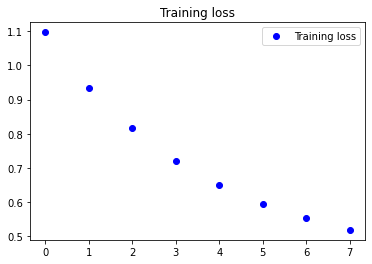

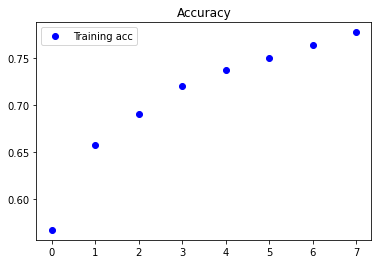

saving model to: model_rawdat_checkpoints/rawmodel_wb_whole_ds.hdf5


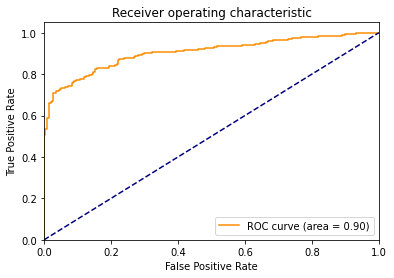

AUC for MCI vs. CN = 0.85
AUC for AD vs. CN = 0.97


In [8]:
# train model on whole ADNI GO/2 dataset
import numpy as np
import gc
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt
%matplotlib inline
import keras
from keras import layers
from keras import models
from keras.callbacks import EarlyStopping
import tensorflow as tf

for k in [1]:
    train_idX = range(numfiles)
    print('Distribution of diagnoses in training data: [1=CN, 3=LMCI, 4=AD]')
    print(grps.iloc[train_idX, :].Group.value_counts())
    
    # Setup 3D CNN model
    tf.set_random_seed(k)
    input_shape = images.shape[1:]
    model = models.Sequential()

    # Convolution Layers
    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu',
              input_shape=input_shape, data_format='channels_last'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv3D(5, (3, 3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(layers.BatchNormalization())
    
    # FC layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer='l2'))
    model.add(layers.Dropout(rate = 0.1))
    model.add(layers.Dense(2, activation='softmax', kernel_regularizer='l2'))

    opt = keras.optimizers.Adam(lr=0.0001) # learning_rate
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    if k==1:
        model.summary()
    
    traindat = images[train_idX, :]
    train_Y = labels[train_idX, :]

    num_train_scans = traindat.shape[0]
    num_copies = 14
    traindatA = np.zeros((num_train_scans*num_copies,) + traindat.shape[1:], dtype=traindat.dtype)
    traindatA[0:num_train_scans, :, :, :, :] = traindat
    traindatA[num_train_scans:(2*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 1) # move around x-axis
    traindatA[2*num_train_scans:(3*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 1)
    traindatA[3*num_train_scans:(4*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 2) # move around y-axis
    traindatA[4*num_train_scans:(5*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 2)
    traindatLRshifted = np.fliplr(traindat) # flip L/R
    traindatA[5*num_train_scans:(6*num_train_scans), :, :, :, :] = traindatLRshifted
    traindatA[6*num_train_scans:(7*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 1) # move around x-axis
    traindatA[7*num_train_scans:(8*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 1)
    traindatA[8*num_train_scans:(9*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 2) # move around y-axis
    traindatA[9*num_train_scans:(10*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 2)
    traindatA[10*num_train_scans:(11*num_train_scans), :, :, :, :] = simpleshift(traindat, 10, 3) # move around z-axis
    traindatA[11*num_train_scans:(12*num_train_scans), :, :, :, :] = simpleshift(traindat, -10, 3)
    traindatA[12*num_train_scans:(13*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, 10, 3)
    traindatA[13*num_train_scans:(14*num_train_scans), :, :, :, :] = simpleshift(traindatLRshifted, -10, 3)

    train_label = np.concatenate((train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y, train_Y,
                                  train_Y, train_Y, train_Y, train_Y, train_Y, train_Y),
                                 axis=0)

    # Fit model to training data
    batch_size = 20
    epochs = 8 # validation accuracy doesn't increase any more after 5 epochs
    hist = model.fit(traindatA, train_label, batch_size=batch_size, epochs=epochs, verbose=1, shuffle=True,
                     #validation_data=(testdat, test_Y), 
                     #callbacks=[EarlyStopping(monitor='acc', mode='auto', verbose=1, patience=2, min_delta=0.02)]
                     class_weight=class_weights)
    # Display models statistics
    from matplotlib import pyplot as plt
    loss = hist.history['loss']
    #val_loss = hist.history['val_loss']
    acc = hist.history['acc']
    #val_acc = hist.history['val_acc']
    epochsr = range(len(loss))
    plt.figure()
    plt.plot(epochsr, loss, 'bo', label='Training loss')
    plt.title('Training loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.plot(epochsr, acc, 'bo', label='Training acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    mymodel = hist.model
    print('saving model to: model_rawdat_checkpoints/rawmodel_wb_whole_ds.hdf5')
    mymodel.save('model_rawdat_checkpoints/rawmodel_wb_whole_ds.hdf5')
    
    # calculate area under the curve
    # AUC as optimization function during training: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    #pred = mymodel.predict(testdat, batch_size=batch_size)
    pred = mymodel.predict(traindat, batch_size=batch_size)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2): # classes dummy vector: 0 - CN, 1 - MCI/AD
        #fpr[i], tpr[i], _ = roc_curve(test_Y[:, i], pred[:,i])
        fpr[i], tpr[i], _ = roc_curve(train_Y[:, i], pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    #Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr[1], tpr[1], color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    # redo AUC for binary comparison: AD vs. HC and MCI vs. HC
    testgrps = grps.iloc[train_idX, :]
    for i in [3,4]:
      grpi = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int)*i)
      grp1 = np.equal(testgrps.Group.to_numpy(dtype=np.int), np.ones((testgrps.shape[0],), dtype=np.int))
      grpidx = np.logical_or(grpi, grp1)
      fpr[i], tpr[i], _ = roc_curve(train_Y[grpidx, 1], pred[grpidx, 1])
      roc_auc[i] = auc(fpr[i], tpr[i])

    print('AUC for MCI vs. CN = %0.2f' % roc_auc[3])
    print('AUC for AD vs. CN = %0.2f' % roc_auc[4])